## Ideas propuestas

Alexis:
Ordenado por dificultad de resolución
1. Escuelas afectadas por el terremoto
2. El material de construcción que más se la bancó (ojo con la media)
4. Número de familias afectadas por el terremoto de manera grave
2. Casas con más daño recibido según tipo construcción
3. Lugar geográfico con más daño recibido


In [44]:
# importacion general de librerias y de visualizacion (matplotlib y seaborn)
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random as rd
%matplotlib inline

plt.style.use('default') # haciendo los graficos un poco mas bonitos en matplotlib
#plt.rcParams['figure.figsize'] = (20, 10)

sns.set(style="whitegrid") # seteando tipo de grid en seaborn

pd.options.display.float_format = '{:20,.2f}'.format # suprimimos la notacion cientifica en los outputs

#import warnings
#warnings.filterwarnings('ignore')

In [45]:
df = pd.read_csv('train_values.csv',nrows=0)
columnas = df.columns.to_list()
datatypes = {
    **{columnas[0]:np.int32}\
    , **{column:np.int16 for column in columnas[1:8] + columnas[27:28]}\
    , **{column:'category' for column in columnas[8:15] + columnas[26:27]}\
    , **{column:np.bool for column in columnas[15:26] + columnas[28:39]}
}
df = pd.read_csv('train_values.csv',dtype=datatypes,usecols=None)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 260601 entries, 0 to 260600
Data columns (total 39 columns):
 #   Column                                  Non-Null Count   Dtype   
---  ------                                  --------------   -----   
 0   building_id                             260601 non-null  int32   
 1   geo_level_1_id                          260601 non-null  int16   
 2   geo_level_2_id                          260601 non-null  int16   
 3   geo_level_3_id                          260601 non-null  int16   
 4   count_floors_pre_eq                     260601 non-null  int16   
 5   age                                     260601 non-null  int16   
 6   area_percentage                         260601 non-null  int16   
 7   height_percentage                       260601 non-null  int16   
 8   land_surface_condition                  260601 non-null  category
 9   foundation_type                         260601 non-null  category
 10  roof_type                       

In [46]:
df2 = pd.read_csv('train_labels.csv',dtype={'building_id':np.int32,'damage_grade':np.int8})

1. Escuelas afectadas por el terremoto. Podría seguir con los lugares afectados


In [69]:
#rename_damage_grade
# def damage_grade(building):
#     levels = {1:'Leve',2:'Medio',3:'Grave'}
#     return levels.get(building['damage_grade'],'unknown')
# cant_esc_daños['damage'] = cant_esc_daños.apply(damage_grade, axis=1)
# cant_esc_daños = cant_esc_daños[['damage','affected_schools']]
# cant_esc_daños
# plt.pyplot.pie(cant_esc_daños)

In [87]:
df = pd.read_csv('train_values.csv',dtype=datatypes,usecols=['building_id','has_secondary_use_school'])
escuelas = df.loc[df['has_secondary_use_school']==True][['building_id']]
escuelas_daños = pd.merge(escuelas,df2,on='building_id',how='inner')[['building_id','damage_grade']]
cant_esc_daños = escuelas_daños.groupby('damage_grade').count().reset_index().rename(columns={'building_id':'affected_schools'})
cant_esc_daños

,damage_grade,affected_schools
0,1,30
1,2,47
2,3,17


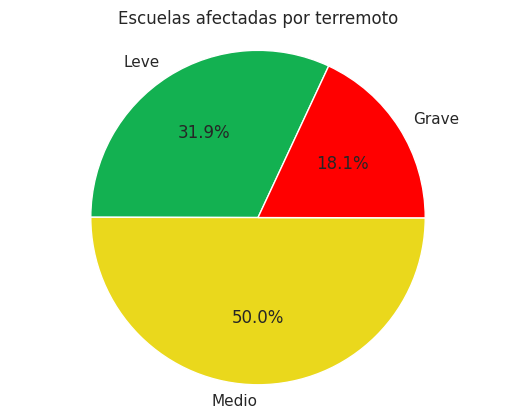

In [100]:
labels = ['Leve','Medio','Grave']
sizes = cant_esc_daños['affected_schools']

fig1, ax1 = plt.subplots()
ax1.pie(sizes,colors = ['#13b151','#ead81c','red'], labels=labels, autopct='%1.1f%%',startangle=65)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.title('Escuelas afectadas por terremoto')
plt.show()

2. El material de construcción que más se la bancó (ojo con la media)

In [28]:
df = pd.read_csv('train_values.csv',dtype=datatypes,usecols=[0]+list(range(15,26))) #building_id + structures
df.iloc[:,1:].apply(pd.value_counts,axis=0)


,has_superstructure_adobe_mud,has_superstructure_mud_mortar_stone,has_superstructure_stone_flag,has_superstructure_cement_mortar_stone,has_superstructure_mud_mortar_brick,has_superstructure_cement_mortar_brick,has_superstructure_timber,has_superstructure_bamboo,has_superstructure_rc_non_engineered,has_superstructure_rc_engineered,has_superstructure_other
False,237500,62040,251654,255849,242840,240986,194151,238447,249502,256468,256696
True,23101,198561,8947,4752,17761,19615,66450,22154,11099,4133,3905
